In [1]:
!git clone https://github.com/zxzhaixiang/QMDB


Cloning into 'QMDB'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 129 (delta 3), reused 11 (delta 2), pack-reused 113
Receiving objects: 100% (129/129), 79.14 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [0]:
datapath = './QMDB/data/movielens_latest/ml-latest-lean/'

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns
from datetime import datetime

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import scipy.stats

%matplotlib inline

In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cuda


## Loading data and prepare data loader

In [0]:
def get_date_time_info(timestamps):
    dt_objs = [datetime.fromtimestamp(ts) for ts in timestamps]
    is_weekend = [1 if dt_obj.weekday()>=5 else 0 for dt_obj in dt_objs]
    hr_of_day = [dt_obj.hour for dt_obj in dt_objs]
    return is_weekend, hr_of_day

In [6]:
print('loading raw rating data..',end='')
rating_df = pd.read_csv(os.path.join(datapath,'ratings.csv'), compression='gzip')

#print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

userIds = rating_df['userId'].unique()

loading raw rating data..

In [0]:
user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)


In [0]:
rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)       

In [9]:
movie_df = pd.read_csv(os.path.join(datapath,'movies.csv'))
movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId')

genres = {a for s in movie_df['genres'] for a in s.split('|')}
print('{} number of movie genres exist. They are '.format(len(genres)), genres)
genres_dict = dict(zip(genres, range(len(genres))))

20 number of movie genres exist. They are  {'(no genres listed)', 'Thriller', 'Film-Noir', 'Crime', 'IMAX', 'Animation', 'Comedy', 'Romance', 'Sci-Fi', 'Documentary', 'Western', 'Adventure', 'Children', 'Mystery', 'Action', 'War', 'Musical', 'Drama', 'Horror', 'Fantasy'}


In [0]:
nM      = movie_df['movieId'].shape[0]
nU      = user_df.shape[0]
nR      = rating_df['rating'].unique().shape[0]
nRecord = rating_df['rating'].shape[0]

In [0]:
is_weekend, hr_of_day = get_date_time_info(rating_df['timestamp'].values)

In [0]:
U    = torch.tensor(rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
M    = torch.tensor(rating_df['movieId'].values, dtype=torch.long).reshape(-1,1)
R    = torch.tensor(rating_df['rating'].values, dtype=torch.float).reshape(-1,1)
IsWeekend = torch.tensor(is_weekend, dtype=torch.float).reshape(-1,1)
hr_of_day = torch.tensor(hr_of_day, dtype=torch.float).reshape(-1,1)


In [0]:
batch_size = 8192
validation_split = .2
shuffle_dataset = True
random_seed = 42

In [0]:
dataset_size = nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [0]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (R[train_idx].numpy()*2).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

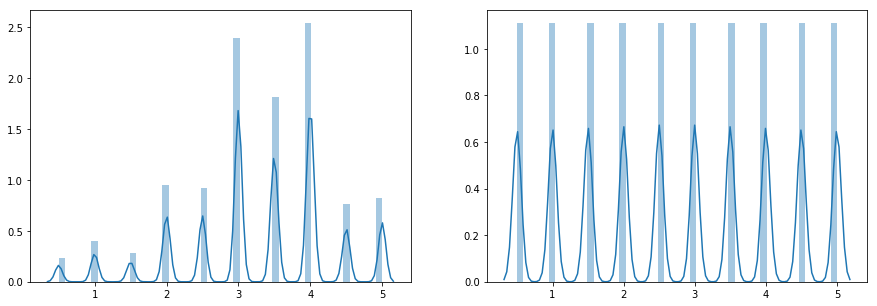

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(R[train_idx])
plt.subplot(122)
sns.distplot(R[train_idx_resampled])

In [16]:
print('Check if resampled indices covers all the original indices: {}'.format(set(train_idx)==set(train_idx_resampled)))

Check if resampled indices covers all the original indices: True


In [0]:
train_dataset = torch.utils.data.TensorDataset(
     torch.tensor(train_idx_resampled, dtype=torch.long), U[train_idx_resampled], M[train_idx_resampled], R[train_idx_resampled])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [0]:
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_idx, dtype=torch.long), U[val_idx], M[val_idx], R[val_idx])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)

## Quick Data Visualization

Text(0.5, 1.0, 'Distribution of movie rating std')

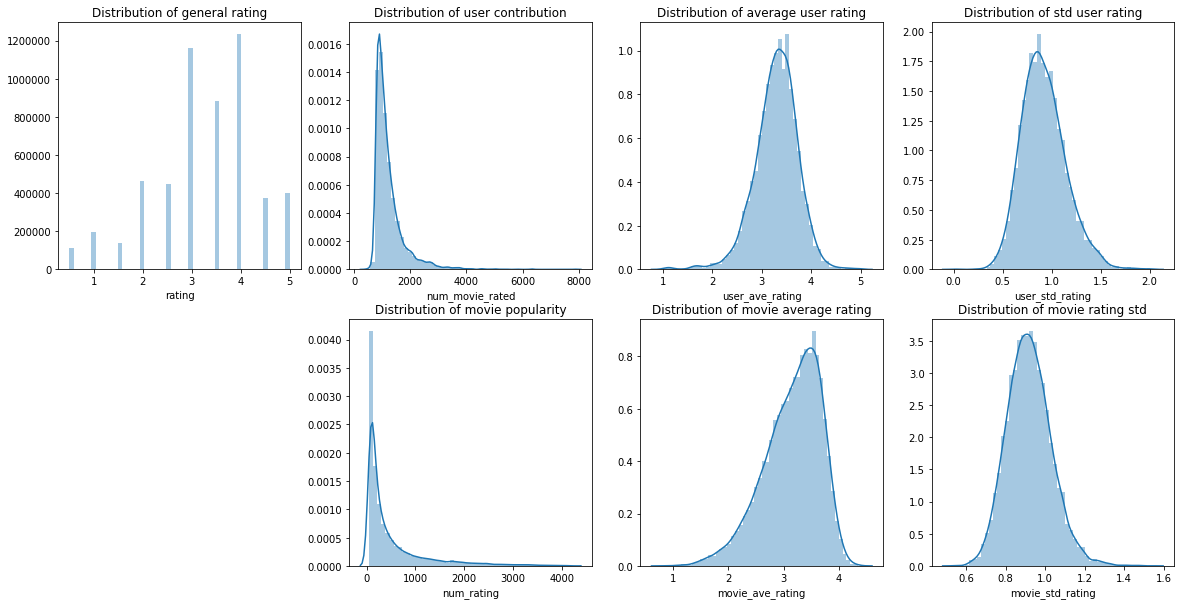

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(241)
sns.distplot(rating_df['rating'], kde=False)
plt.title('Distribution of general rating')

plt.subplot(242)
sns.distplot(user_df['num_movie_rated'])
plt.title('Distribution of user contribution')

plt.subplot(243)
sns.distplot(user_df['user_ave_rating'])
plt.title('Distribution of average user rating')

plt.subplot(244)
sns.distplot(user_df['user_std_rating'])
plt.title('Distribution of std user rating')

plt.subplot(246)
sns.distplot(movie_df['num_rating'])
plt.title('Distribution of movie popularity')

plt.subplot(247)
sns.distplot(movie_df['movie_ave_rating'])
plt.title('Distribution of movie average rating')

plt.subplot(248)
sns.distplot(movie_df['movie_std_rating'])
plt.title('Distribution of movie rating std')



## Build model

In [0]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.item_dim = config['nItems']        
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.item_embedding = nn.Embedding(self.item_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, item_id):
        
        user_em = self.user_embedding(user_id)
        item_em = self.item_embedding(item_id)
        return self.cos_sim(user_em,item_em)*5
        

In [0]:
config = {'nUsers': nU, 'nMovies': nM, 
          'nGenres': len(genres),
          'user_latent_dim': 128, 'item_latent_dim': 128}
print(config)


{'nUsers': 923, 'nItems': 6335, 'user_latent_dim': 128, 'item_latent_dim': 128}


In [0]:
CF = NCF(config).to(device)

In [0]:
CF_criterion = nn.MSELoss()
CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.002, betas = (0.5, 0.999))

## Training

In [0]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss=0), display_id = True)

    def update(self, i, loss=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss=loss))
    
    def progress(self, value, loss=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss={loss:0.5f} <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value,M=M,loss=loss))

In [0]:
train_losses = []
val_losses = []
train_losses_epoch = []
val_losses_epoch = []

In [0]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

358 mini-batches in training dataset, 41 mini-batches in validation dataset


In [0]:
epoch_num = 50

In [0]:
def lr_schedular(optimizer, epoch):
    if(epoch<10):
        lr = 0.001
    elif(epoch<20):
        lr = 0.0005
    elif (epoch<30):
        lr = 0.00025
    else:
        lr = 0.0001

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

Training epoch 0/50


epoch[0/50], train loss = 5.2446344145183454, val loss = 1.0391974274705096


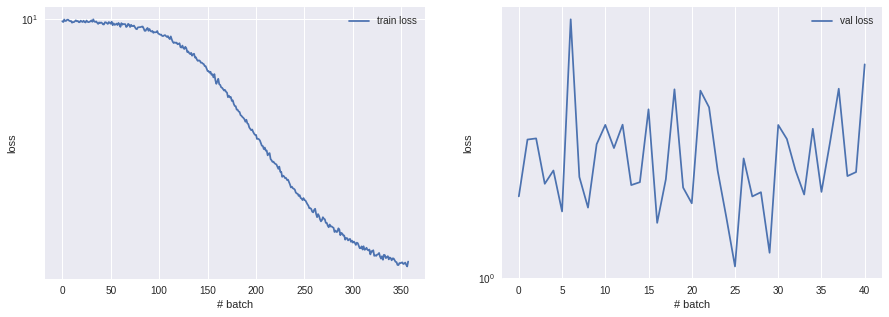

Training epoch 1/50


epoch[1/50], train loss = 0.9439860492445237, val loss = 0.771961204889344
Training epoch 2/50


epoch[2/50], train loss = 0.7642257837942859, val loss = 0.7058584661018558
Training epoch 3/50


epoch[3/50], train loss = 0.6751837374111793, val loss = 0.6780027456399871
Training epoch 4/50


epoch[4/50], train loss = 0.6260778477738024, val loss = 0.657449986876511
Training epoch 5/50


epoch[5/50], train loss = 0.5977541259880172, val loss = 0.6437928080558777


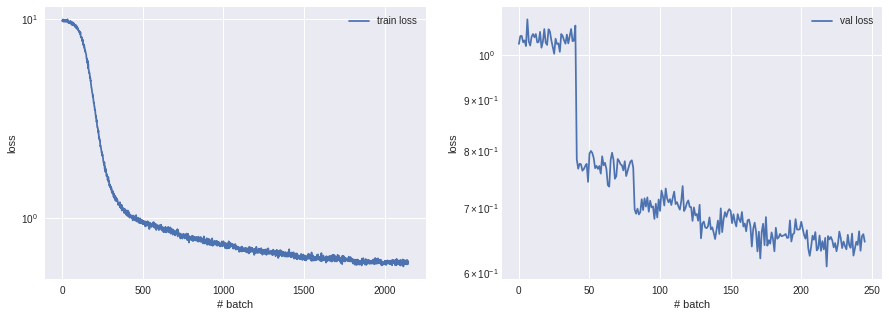

Training epoch 6/50


epoch[6/50], train loss = 0.5815496191632148, val loss = 0.6415139000590254
Training epoch 7/50


epoch[7/50], train loss = 0.5720834965146454, val loss = 0.6364514900416862
Training epoch 8/50


epoch[8/50], train loss = 0.5662663767124687, val loss = 0.6315068704325978
Training epoch 9/50


epoch[9/50], train loss = 0.5626158852483973, val loss = 0.6290006230517131
Training epoch 10/50


epoch[10/50], train loss = 0.5508287265980044, val loss = 0.6179005285588707


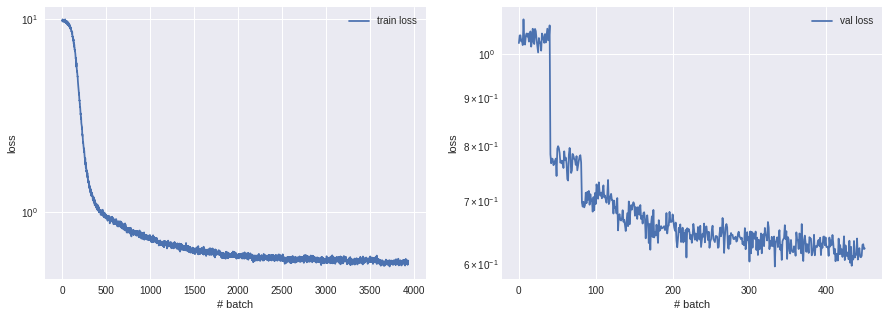

Training epoch 11/50


epoch[11/50], train loss = 0.5478020516853759, val loss = 0.6196448701183971
Training epoch 12/50


epoch[12/50], train loss = 0.5469192539513444, val loss = 0.618795897902512
Training epoch 13/50


epoch[13/50], train loss = 0.5460877903013922, val loss = 0.6180222834028849
Training epoch 14/50


epoch[14/50], train loss = 0.5454144582735093, val loss = 0.6181912582095076
Training epoch 15/50


epoch[15/50], train loss = 0.5447747028073785, val loss = 0.6172448207692403


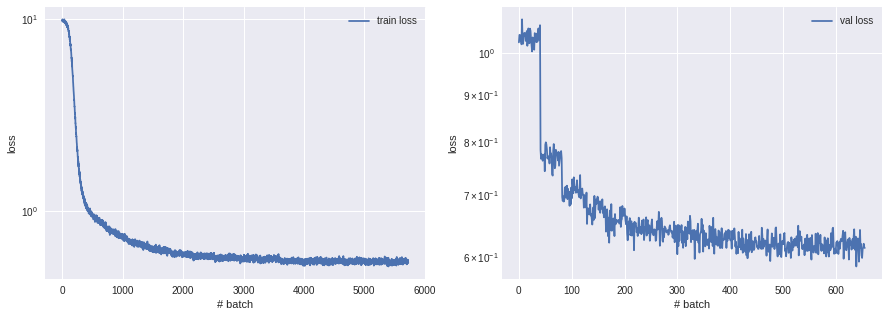

Training epoch 16/50


epoch[16/50], train loss = 0.5443274085748129, val loss = 0.6166759336866984
Training epoch 17/50


epoch[17/50], train loss = 0.5439889038075282, val loss = 0.6176842058577189
Training epoch 18/50


epoch[18/50], train loss = 0.5435275074156969, val loss = 0.6170145709340166
Training epoch 19/50


epoch[19/50], train loss = 0.5431254815788908, val loss = 0.6173024686371408
Training epoch 20/50


epoch[20/50], train loss = 0.5371161569430175, val loss = 0.612890156303964


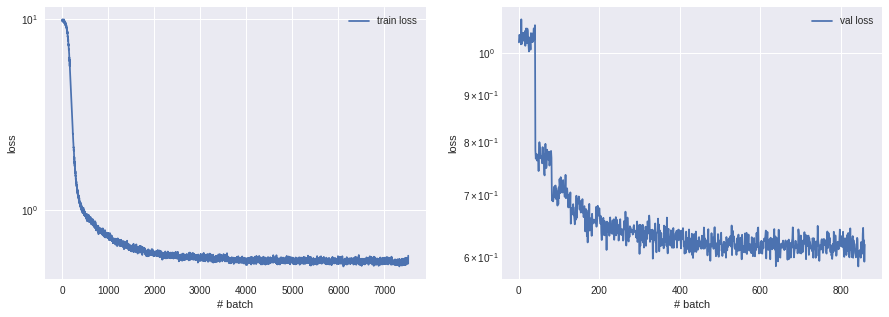

Training epoch 21/50


epoch[21/50], train loss = 0.5357933136004975, val loss = 0.613210157650273
Training epoch 22/50


epoch[22/50], train loss = 0.535525502938798, val loss = 0.6125301922239909
Training epoch 23/50


epoch[23/50], train loss = 0.5352173029710461, val loss = 0.6129530959013032
Training epoch 24/50


epoch[24/50], train loss = 0.5351450478231441, val loss = 0.6127616356058818
Training epoch 25/50


epoch[25/50], train loss = 0.5350403176339645, val loss = 0.6126317003878151


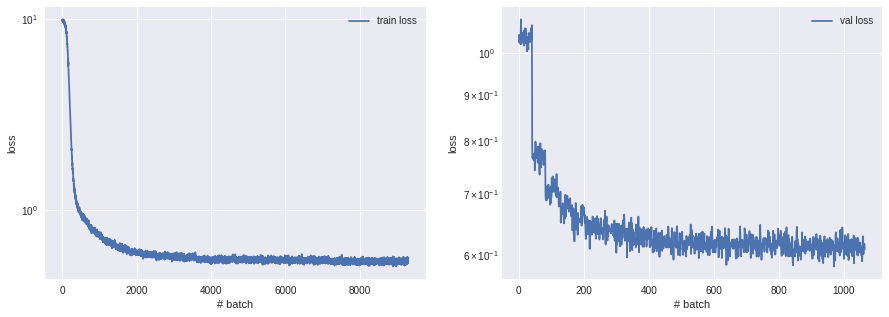

Training epoch 26/50


epoch[26/50], train loss = 0.534798283483729, val loss = 0.6128061937122811
Training epoch 27/50


KeyboardInterrupt: ignored

In [0]:
for epoch in range(epoch_num):
    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    train_loss = 0
    val_loss = 0
    tmp_loss = 0
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    for i,(users, movies, ratings) in enumerate(train_loader):
        pbar.update(i+1, tmp_loss)
        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        #U,I = torch.tensor(users, dtype=torch.long).to(device), torch.tensor(movies, dtype=torch.long).to(device)
        rhat = CF(U,I)
        
        loss = CF_criterion(rhat, R)
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        tmp_loss = loss.item()
        train_loss += loss.item()
        train_losses.append(loss.item())

    train_loss/=nBatch_train
    train_losses_epoch.append(train_loss)
    
    for i, (u,m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        rhat = CF(U,I)
        loss = CF_criterion(rhat,R)
        val_loss += loss.item()
        val_losses.append(loss.item())
        
    val_loss/=nBatch_val
    val_losses_epoch.append(val_loss)
    
    print('epoch[{}/{}], train loss = {}, val loss = {}'.
         format(epoch, epoch_num, train_loss, val_loss))
    
    if (epoch%5==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

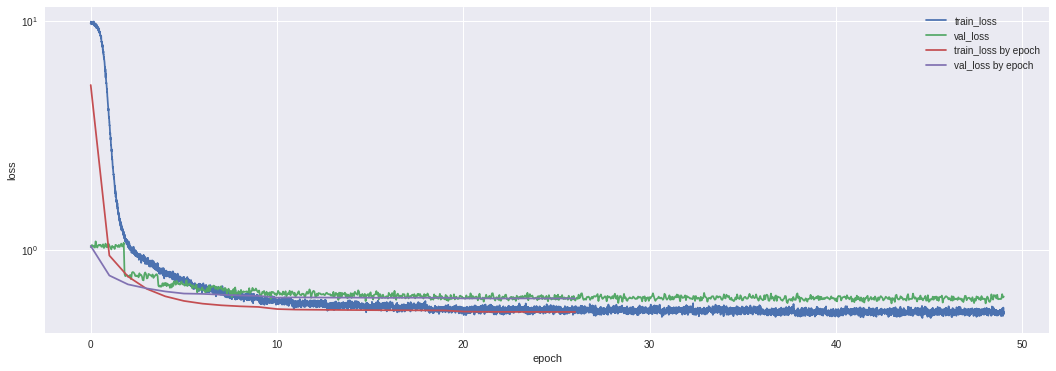

In [0]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch_num-1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch_num-1, len(val_losses)),val_losses,label='val_loss')
plt.plot(train_losses_epoch,label='train_loss by epoch')
plt.plot(val_losses_epoch,label='val_loss by epoch')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

In [0]:
r_real = []
r_pred = []


for i, (u,m,r) in enumerate(val_loader):
    U, I= u.to(device), m.to(device)
    rhat = CF(U,I)
    r_real+=list(r.detach().cpu().numpy().reshape(-1))
    r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))    
    if(i%20==0):
        print('{}/{}'.format(i,nBatch_val))

0/41
20/41
40/41


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [0]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

In [0]:
print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -0.21532437205314636, std = 0.7532592415809631
mae = 0.6022570133209229
rmse = 0.7834309339523315
slope=0.5425758997434775, r2=0.693083856801708
pearson = 0.6930837631225586, spearman = 0.6695617935231252


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

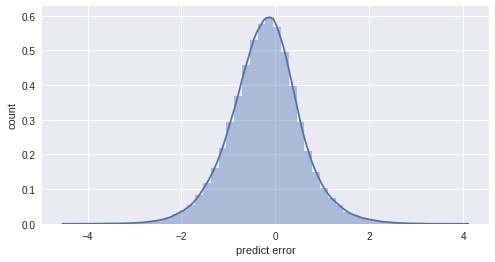

In [0]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = r.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(ML_Data.movie_df, how='left', on='movieId')
pd_df = pd_df.merge(ML_Data.user_df, how='left', on='userId')
pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [0]:
pd_df.head(50)

,movieId,pred,real,userId,title,year,num_rating,movie_ave_rating,movie_std_rating,num_movie_rated,user_ave_rating,user_std_rating
0,4596,2.903985,3.5,234,X-Men: The Last Stand,2006,622,3.040193,0.963918,2156,3.209879,0.880118
1,1903,3.664355,3.5,3,Bicycle Thieves (a.k.a. The Bicycle Thief) (a....,1948,333,3.981982,0.974667,1392,3.156250,0.635498
2,1021,3.918827,3.5,250,"Truman Show, The",1998,856,3.761098,0.848387,1733,3.638777,0.893062
3,3678,3.199720,3.0,546,"Midnight Clear, A",1992,94,3.547872,0.904199,1617,3.127087,0.759076
4,2252,2.918618,1.5,116,"Conversation, The",1974,504,3.935516,0.910677,2589,2.989378,1.010371
5,6285,0.899267,0.5,266,King Arthur: Legend of the Sword,2017,90,2.883333,0.968753,2512,1.664013,1.437664
6,3737,3.175225,3.0,861,Diabolique (Les diaboliques),1955,250,3.976000,0.803746,1716,2.618590,1.244490
7,4687,2.180627,3.0,114,Saw III,2006,263,2.568441,1.048933,1408,3.663707,1.094184
8,3979,2.978261,3.5,377,Night of the Living Dead,1990,180,3.088889,0.967568,1624,3.227217,0.667047
9,3131,2.240011,2.5,666,Signs,2002,775,3.155484,1.007731,1196,2.980351,0.880418


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


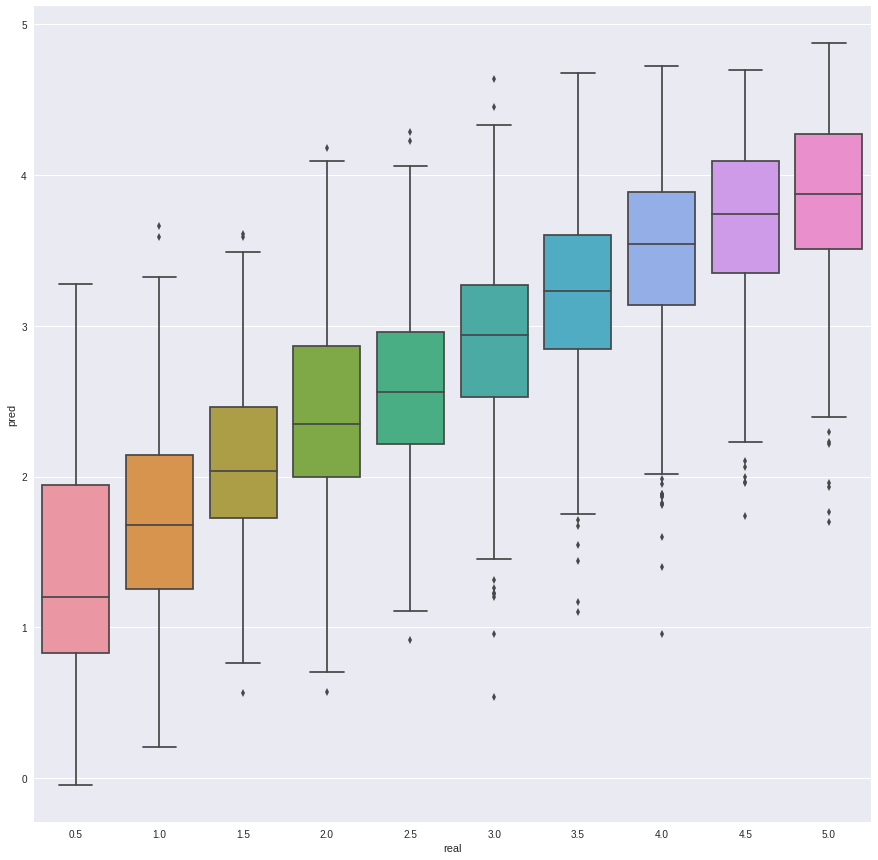

In [0]:
plt.figure(figsize=(15,15))
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


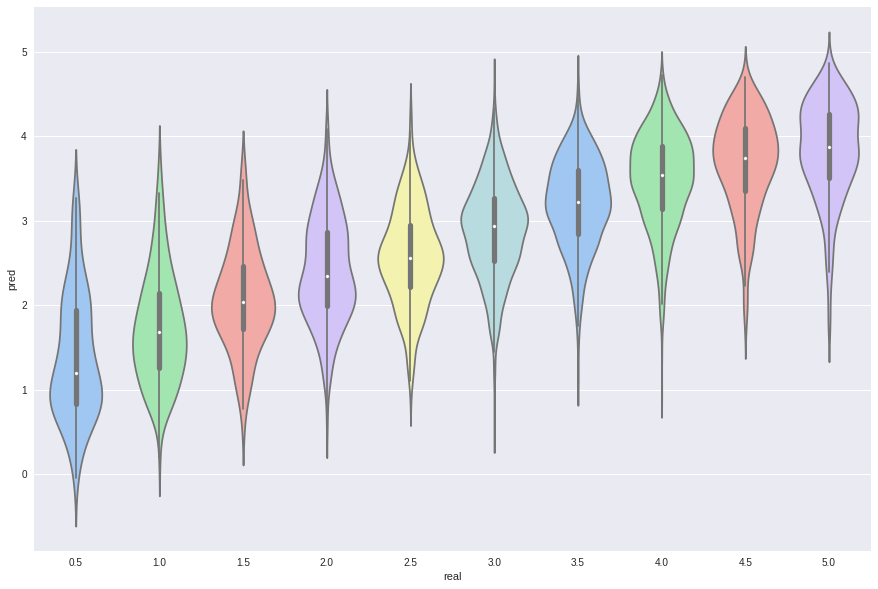

In [0]:
plt.figure(figsize=(15,10))
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


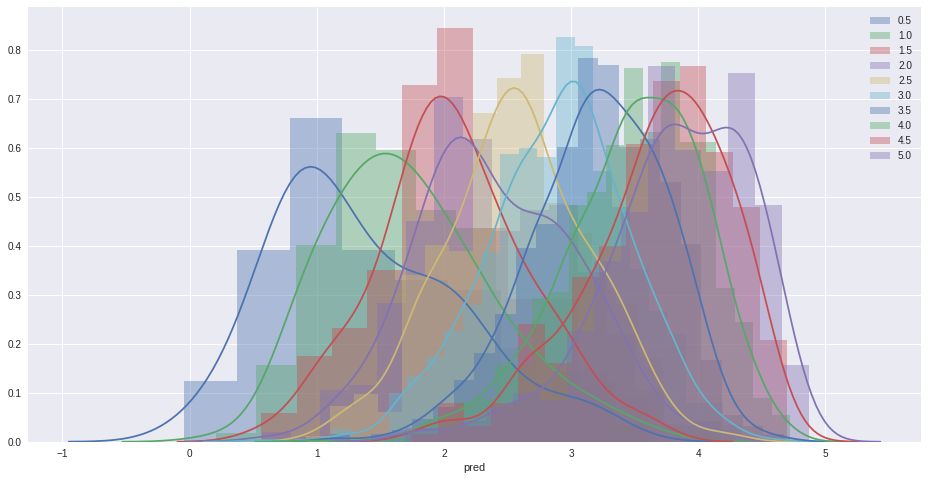

In [0]:
rs = list(pd_df['real'].unique())
rs.sort()
plt.figure(figsize=(16,8))
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*2)/2))
plt.legend()

In [0]:
Movie_Em = CF.item_embedding.weight.data.detach().cpu().numpy()

In [0]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


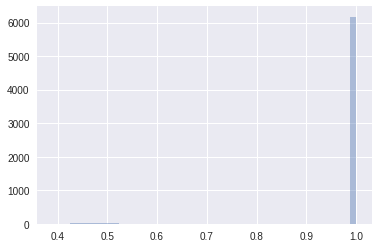

In [0]:
sns.distplot(L,kde=False)

In [0]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

(-9.245987361201498, 10.54380213965726, -7.944055788078451, 10.901116184122028)

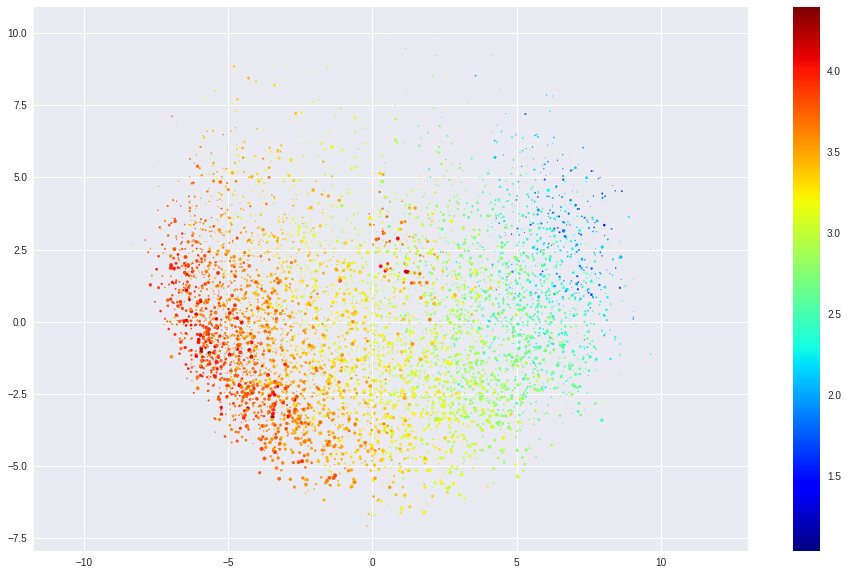

In [0]:
plt.figure(figsize=(16,10))

ss = (ML_Data.movie_df['num_rating'].values - ML_Data.movie_df['num_rating'].min())/60

plt.scatter(M_pca[:,0], M_pca[:,1], c = ML_Data.movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')

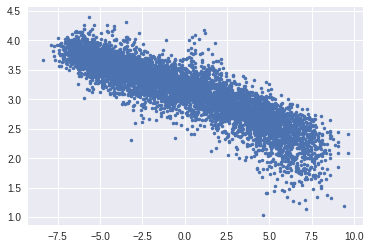

In [0]:
plt.plot(M_pca[:,0], ML_Data.movie_df['movie_ave_rating'],'.')

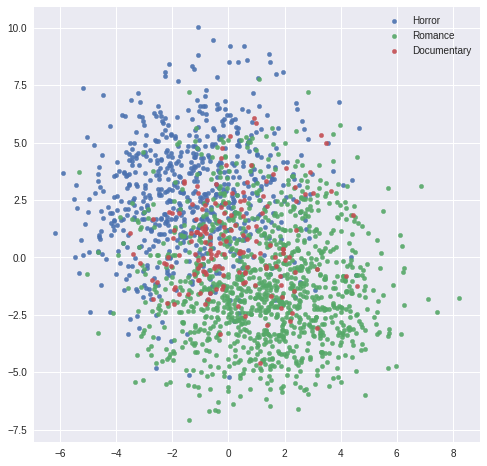

In [0]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['Horror','Romance','Documentary']:
    ind = ML_Data.movie_df.index[ML_Data.movie_df[g] == 1].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()


(-6.476209, 4.857848)

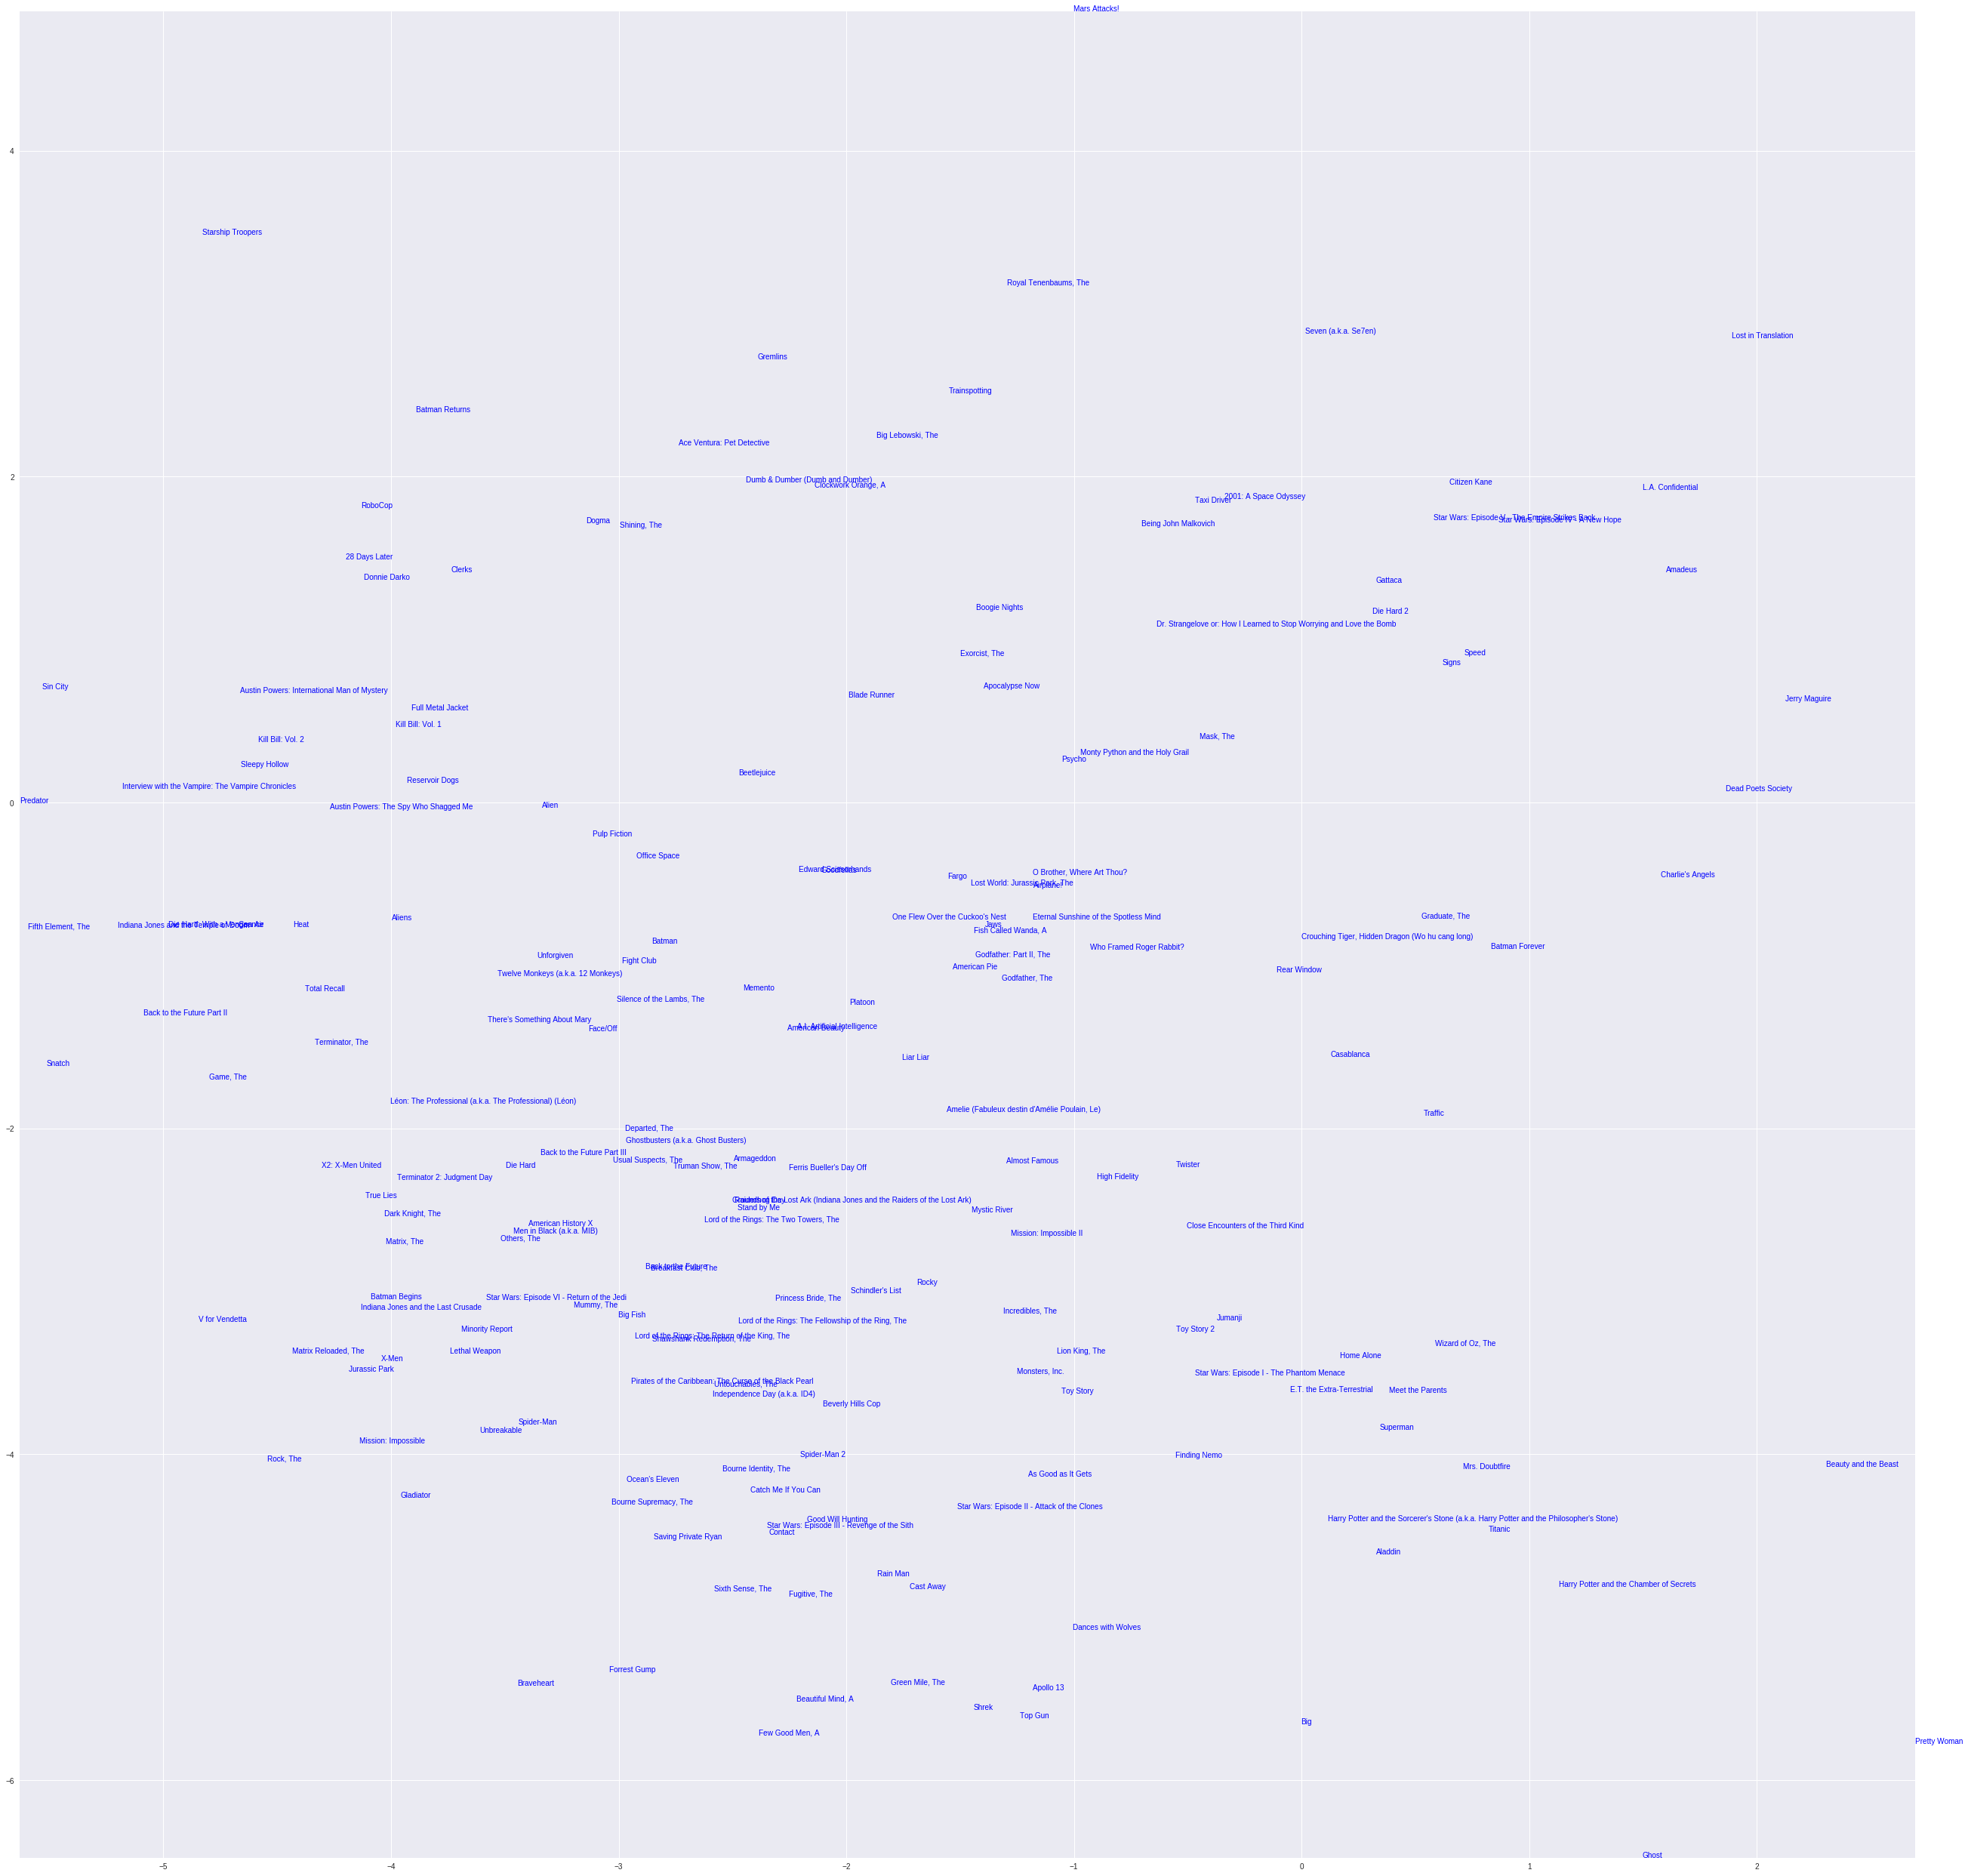

In [0]:
TopMovies_id = ML_Data.movie_df['num_rating'].nlargest(200).index.values

plt.figure(figsize=(45,45))
#plt.scatter(M_pca[:,0], M_pca[:,1])

xs = []
ys = []

for i in TopMovies_id:
    t = ML_Data.movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    #if(x>xlim[0] and x<xlim[1] and y>ylim[0] and y<ylim[1]):
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = Movie_Em/L

In [0]:
Movie_S = np.matmul(Movie_Em, Movie_Em.T)

In [0]:
for i in range(50):
    movie_id = TopMovies_id[i]
    t = ML_Data.movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(ML_Data.movie_df['movie_ave_rating'][tmp_id]>2.5):
            t = ML_Data.movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Terminator 2: Judgment Day
   Dark Knight, The
   Shawshank Redemption, The
   Léon: The Professional (a.k.a. The Professional) (Léon)
   Lord of the Rings: The Fellowship of the Ring, The
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Star Wars: Episode V - The Empire Strikes Back
   Usual Suspects, The
   Inception
   Star Wars: Episode IV - A New Hope
   Lord of the Rings: The Two Towers, The

Movie:Silence of the Lambs, The
   Usual Suspects, The
   Aliens
   Memento
   One Flew Over the Cuckoo's Nest
   Alien
   Terminator 2: Judgment Day
   Schindler's List
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Pulp Fiction
   Die Hard
   Goodfellas

Movie:Back to the Future
   Die Hard
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Terminator 2: Judgment Day
   Star Wars: Episode V - The Empire Strikes Back
   Groundhog Day
   Shawshank Redemption, The
   Star Wars: Episode 